# Industry sentiment analysis from twitter feed - Phase 1 (Sentiment Classification)

This intent of this notebook is to demonstrate a neural network's ability to sentiment classify tweets. This notebook will be the 1st in a series of notebooks that will demonstrate capabilities that are required to built the project "Industry sentiment analysis from twitter feed".  Details of this project is available at :

http://innovativespur.com/industry-sentiment-analysis-from-twitter-feed/

This notebook being the phase 1, lays down the python codes in developing a tweet sentiment classification (positive, neutral and negative) Recurrent Neural Network (RNN) model which in a later phase be integrated into real time sentiment classification.

Objectives :
1. Read a set of training tweets with classification
2. Read and import the pre-trained  GloVe(Global Vectors for Word Representation) embedding weights from the official website https://nlp.stanford.edu/projects/glove/ 
3. Convert tweet sentences into a one-hot representation array with a maximum of 30 words basis the above downloaded GloVe embeddings
4. Convert the one hot indexed representation to a vector representation basis the GloVe embeddings
5. Create a simple RNN model with LSTM inputting vectorized embeddings with 128 units and a single output into a softmax classifier
6. Training the model for 20 epocs
4. Saving the trained model and using for predictions


## Importing relevant libraries and the dataset

I am using the below libraries in python with GPU acceleration:
1. Numpy
2. Pandas
3. Collections
4. Re
5. Keras
6. Tensorflow
7. Matplotlib

The dataset for training sentiment classification is from the below kaggle link:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import re as re

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

import matplotlib.pyplot as plt

data = pd.read_csv('data/Tweets.csv')
data.head()

Using TensorFlow backend.


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Reading and spliting the dataset into test and training sub-sets

In [2]:
reviews = np.array(data['text'][:14000])
labels = np.array(data['airline_sentiment'])[:14000]
Counter(labels)

Counter({'neutral': 3017, 'positive': 2304, 'negative': 8679})

### Splitting the data into training, validation and testing datasets

80% of the dataset has been split into training dataset and the remaining equally into validation and testing dataset.

In [4]:
split_frac = 0.9

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(reviews)*split_frac)
train_x, test_x = reviews[:split_idx], reviews[split_idx:]
train_y, test_y = labels[:split_idx], labels[split_idx:]


## print out the shapes of the resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nTest set: \t\t{}".format(test_x.shape))
print(np.shape(train_y))

			Feature Shapes:
Train set: 		(12600,) 
Test set: 		(1400,)
(12600,)


## Importing the GloVe word to vector mapping

For the word embeddings, I use the 25 dimensional Twitter GloVe embeddings published by the Stanford University. This embedding has a vocabulary size of approx. 1.2 million and seemed perfect for the sentiment classification of tweets.

A function named "read_glove_vectors" have been defined that accepts the file name and encoding format as inputs and returns dictionaries that maps words to indices, its vector representation and indices back to word vectors. The function ignores a vector representation if there is no 25 dimensions to its encoded vectors.

In [5]:
def read_glove_vectors(file_name, encode):
    
    emb_file = open(file_name, encoding=encode)
    
    # Dictionary to store the output
    word_to_vector_map = dict()
    word_to_index = dict()
    index_to_word =dict()

    #Converting Glove embeddings into a dictionary
    i = 1
    for line in emb_file:
        values = line.split()
        
        if len(values[1:]) == 25:                           #Checking if any line misses the 25 dimention embeddings
            word = values[0]
            word_to_index[word] = i
            index_to_word[i] = word
            i = i+1    
            coefs = np.asarray(values[1:], dtype='float32')
            word_to_vector_map[word] = coefs
    emb_file.close()
    
    return word_to_vector_map, word_to_index, index_to_word


In [6]:
file_name = 'glove.twitter.27B.25d.txt'
encode = 'utf8'
word_to_vector_map, word_to_index, index_to_word = read_glove_vectors(file_name, encode)

In [7]:
#Test Code

print(index_to_word[1])


print('Loaded %s word vectors.' % len(word_to_vector_map)) # Checking vocab size

print(word_to_vector_map['cucumber'])

<user>
Loaded 1193513 word vectors.
[-0.93892  -0.53106  -0.076851  1.2284   -0.42073   0.57278   0.27791
 -2.0537    0.16232  -0.17612   0.91642  -0.28016  -1.4326   -1.5892
  0.27062  -0.82859   1.2586   -0.47312   0.44714   0.62342  -0.12856
  0.83153  -0.042993  0.41788   0.39497 ]


## Functions and dictionaries to pre-process the dataset

Of the dataset, the variables relevant for sentiment classification are the text and Airline Sentiment. Both of theses variable values have been filtered out and stored in 2 arrays in the initial steps. In this step, I define functions and dictionaries that can further process the tweets and labels datasets to a desirable form for model creation and evaluation. 
    

### Pre-Processing the tweet dataset

To classify tweets into sentiment buckets, I felt it would be wise to reduce the tweets by filtering out "@" references, punctuations and links to other websites. Such elements contribute barely if not any to the sentiment of a tweet.

#### Function to sanitize tweets text data
Below I have defined a function that accepts a sentence string and converts it to a list of words in a sentence sans punctuation, "@" references and external website links.

In [8]:
# Function that accepts a sentence string and coonverts it to a list of words in a sentence sans punctuation, "@" references and external website links

def sentence_to_list(sentence):
    punctuation = '!"#$%&\'()*+,-./:;<=>?[\\]^_`{|}~'
    
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    sentence_list = sentence.split()
    sentence_list = [word for word in sentence_list if not re.match('^@',word)]
    sentence_list = [word for word in sentence_list if not re.match('^http',word)]
    
    return sentence_list

#### Function to convert tweet sentence array to word index array of max length 30

This function defined below accepts a set of tweets, sanitizes it for unwanted words and characters as detailed in the tweet sanitisation function and converts it into an array with the number of sentences as the number of rows and 30 columns representing the maximum number of words accepted in a sentence. Short sentences will have 0 as padding to standardize it to 30 word length.

In [9]:
# Function to accept sentence arrays and return a number of sentense by 30 beingthe max sentence word lenght

def sendence_list_to_index(sendence_array):
    m = sendence_array.shape[0]
    max_len = 30
    na_value = len(word_to_index)
    
    X_indices = np.zeros((m , max_len))
    
    
    for i in range(m):
        sentence_words = sentence_to_list(sendence_array[i])
        j=0
        for w in sentence_words:
            X_indices[i, j] = word_to_index.get(w)
            j = j+1
            if j == max_len:
                break
    return X_indices

In [10]:
# Sample test code

sample_sents = np.array(['I love You #$% @Swamy http://www.innovativespur.com', 'Life is so beautiful XOXO', 'Too hot to handle ###','OOh my god'])

sample = []

for sentence in sample_sents:
    sample.append(sentence_to_list(sentence))
    
print(sample)

print(max([len(sentence_list) for sentence_list in sample]))

print(type(reviews))

print(sample_sents.shape[0])


sendence_list_to_index(sample_sents)

[['i', 'love', 'you'], ['life', 'is', 'so', 'beautiful', 'xoxo'], ['too', 'hot', 'to', 'handle'], ['ooh', 'my', 'god']]
5
<class 'numpy.ndarray'>
4


array([[  11.,   69.,   16.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [ 182.,   33.,   56.,  533., 4326.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [ 157.,  560.,   17., 2834.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [3950.,   30.,  331.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]])

### Pre-Processing the tweet sentiment category

The tweet sentiment categories are to be converted to one hot encoding with 3 category buckets. 
I am defining four functions for the below purpose:
1. Accept labels dataset and return back dictionaries for label to index mapping and index to label mapping
2. Accept labels dataset and label to index mapping and return back an array with each row representing the category indices
3. Accept the category indexed labels array and return back a one-hot encoded array with the number of labels as the number of rows
4. Accept an array of categories and return back a one hot encoded categorization

In [11]:
# Function to labels dataset and return back dictionaries for label to index mappign and index to label mapping

def categories_to_indices(labels_in):
    labels_u = np.unique(labels_in)
    index = [i for i in range(labels_u.shape[0])]
    label_to_index = dict(zip(labels_u, index))
    index_to_label = dict(zip(index, labels_u))
    return label_to_index, index_to_label

In [12]:
# Creating the label to index and index to label dictionaries

label_to_index, index_to_label = categories_to_indices(labels)

In [13]:
#function to convert labels into one hot indices array

def one_hot_labels(labels_in, label_to_index ):
    labels_oh = np.array([label_to_index[i] for i in labels_in])
    return labels_oh

In [14]:
#function to convert one hot indices array into binary one hot array

def one_hot_encoding(one_hot_index):
    b = np.zeros((one_hot_index.size, one_hot_index.max()+1))
    b[np.arange(one_hot_index.size),one_hot_index] = 1
    return b

In [15]:
#function to accept label arrays and output one hot encoded arrays

def labels_to_onehot(labels_in, label_to_index):
    labels_ohi = one_hot_labels(labels_in, label_to_index)
    labels_oh = one_hot_encoding(labels_ohi)
    return labels_oh

## Modeling the RNN tweet sentiment classification model

The model that I propose to use is a basic RNN model that accepts 30 input word indices, encodes it into a 25 dimensional pre-trained GloVe weights and is passed into a 128 dimensional Long Short Term Memory (LSTM) unit that has a single output at the end that outputs a softmax activated 3 dimensional array which predicts the tweet sentiment class. I am incorporating a dropout layer with a probability of 50%.
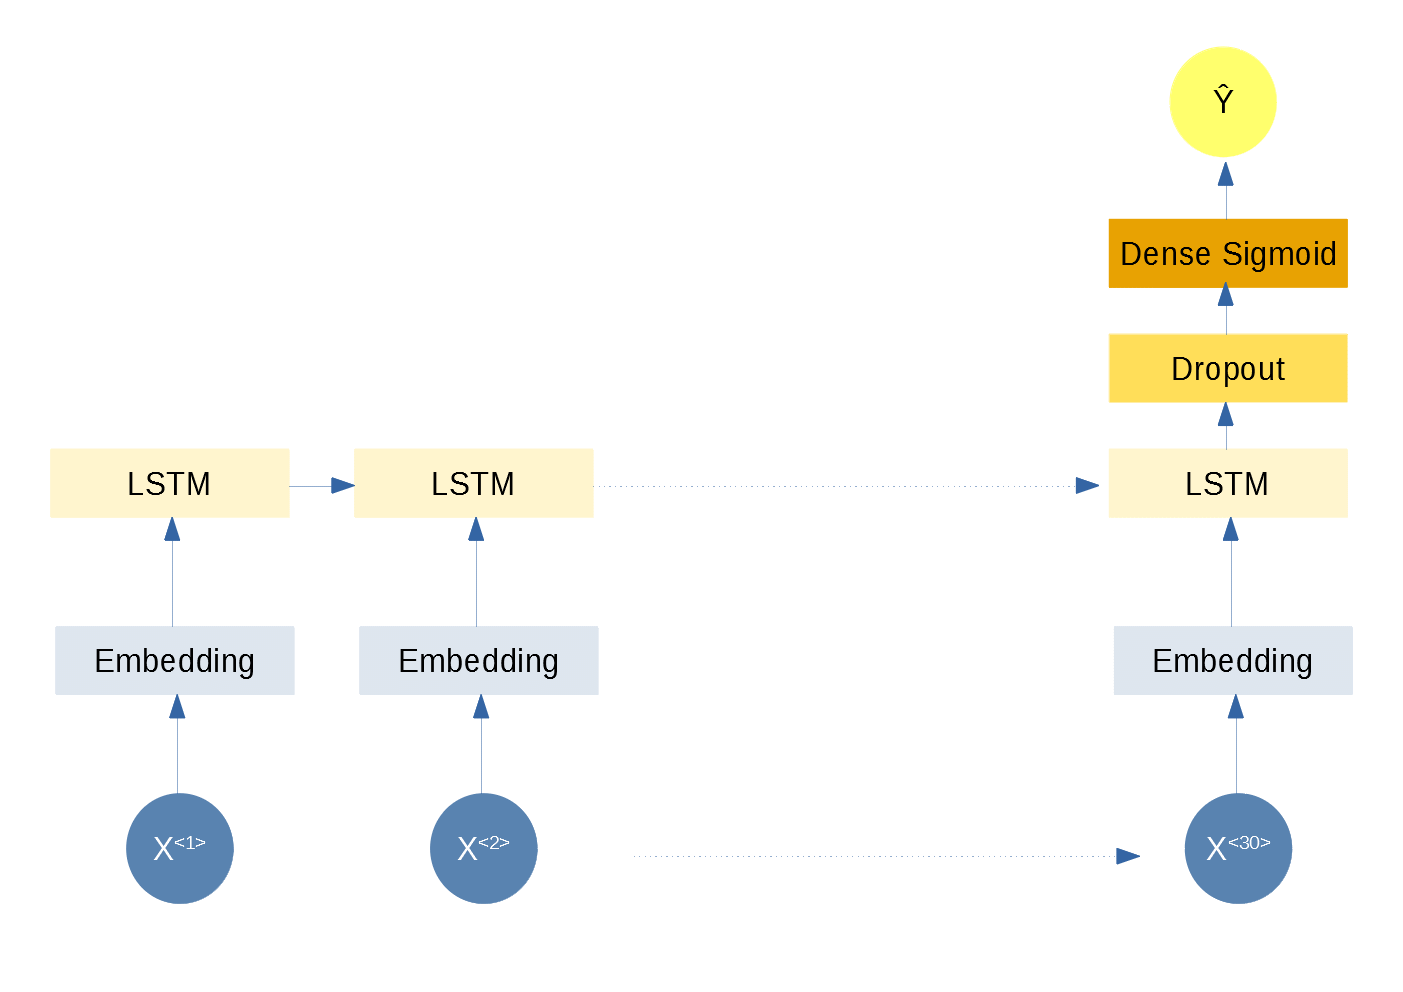
_Figure 1 : Illustrative representation of the twitter sentiment classification model_

### Function that returns a pre-trained embedding layer

Below I am defining a function that can return a pre-trained embedding layer basis the 25 dimensional twitter GloVe embeddings.  The function accepts mapping of words to glove vectors and word to its constituent indices.

In [16]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):

    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    
    emb_matrix = np.zeros((vocab_len,emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]


    embedding_layer = Embedding(vocab_len, emb_dim,trainable = False, mask_zero=True)

    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [17]:
sample_Layer = pretrained_embedding_layer(word_to_vector_map, word_to_index)
sample_Layer.get_weights()[0][0]
#word_to_index['<blank_padding>']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Function to return the prediction model

Function that returns the model for prediction basis the model architecture defined in figure 1.

In [18]:
def Twitter_Sentiment_Model(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    X = LSTM(units=128, return_sequences = False)(embeddings)
    X = Dropout(rate = 0.5)(X)
    X = Dense(units = 3)(X)
    X = Activation('softmax')(X)
    model = Model(inputs = sentence_indices, outputs= X)
    return model
    

### Defining and training the model

In [19]:
# Initiating the model

max_len = 30
model = Twitter_Sentiment_Model((max_len,), word_to_vector_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 25)            29837850  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               78848     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 29,917,085
Trainable params: 79,235
Non-trainable params: 29,837,850
__________________________________________

In [20]:
# Compiling the model 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Defining the training dataset using the functions defined before

X_train_indices = sendence_list_to_index(train_x)

Y_train_oh = labels_to_onehot(train_y, label_to_index)

In [22]:
#Test Code

print(np.shape(Y_train_oh), np.shape(Y_train_oh), np.shape(train_y))

(12600, 3) (12600, 3) (12600,)


In [23]:
# Training the model for 15 Epochs

history = model.fit(X_train_indices, Y_train_oh, epochs = 15, batch_size = 32, shuffle=True, validation_split=0.10)

Train on 11340 samples, validate on 1260 samples
Epoch 1/15
11340/11340 [==============================] - 40s 4ms/step - loss: 0.7305 - accuracy: 0.7030 - val_loss: 0.6149 - val_accuracy: 0.7667
Epoch 2/15
11340/11340 [==============================] - 38s 3ms/step - loss: 0.6578 - accuracy: 0.7338 - val_loss: 0.6092 - val_accuracy: 0.7563
Epoch 3/15
11340/11340 [==============================] - 38s 3ms/step - loss: 0.6327 - accuracy: 0.7445 - val_loss: 0.5909 - val_accuracy: 0.7762
Epoch 4/15
11340/11340 [==============================] - 38s 3ms/step - loss: 0.6122 - accuracy: 0.7537 - val_loss: 0.5854 - val_accuracy: 0.7738
Epoch 5/15
11340/11340 [==============================] - 37s 3ms/step - loss: 0.5950 - accuracy: 0.7622 - val_loss: 0.5693 - val_accuracy: 0.7786
Epoch 6/15
11340/11340 [==============================] - 37s 3ms/step - loss: 0.5791 - accuracy: 0.7614 - val_loss: 0.5643 - val_accuracy: 0.7706
Epoch 7/15
11340/11340 [==============================] - 37s 3ms/ste

In [24]:
# Saving the trained model

model.save('Twitter_Sentiment_Model.h5')

### Visualizing the history of model optimization 

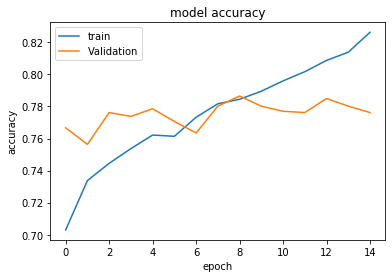

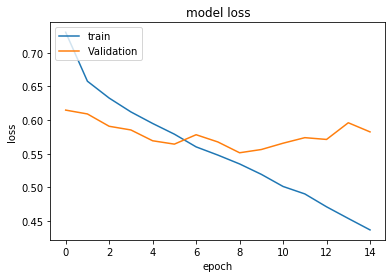

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Testing the trained model on test data

In [26]:
# Testing the model with one sentense

x_test = np.array(['experience is like having fun'])
X_test_indices = sendence_list_to_index(x_test)

In [27]:
index_to_label[np.argmax(model.predict(X_test_indices))]

'negative'

In [28]:
# Checking for GPU acceleration

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
# Testing on test data

X_test_indices = sendence_list_to_index(test_x)
Y_test_oh = labels_to_onehot(test_y, label_to_index)

loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

1400/1400 [==============================] - 1s 606us/step

Test accuracy =  0.8264285922050476


## Conclusion

The model seems to perform with approx. 80% accuracy in sentiment prediction. This is based on the freely available twitter sentiment classified tweet dataset for the airline industry.  Our end objective is to use the model for sentiment classification of any industry and not just the airline industry.  Therefore, for the future iterations I plan to re-train using a custom prepared sentiment classified, industry classified news feed tweet dataset.  

## References

1. Twitter Sentiment Classification by Andika Rachman https://github.com/andikarachman/RNN-Twitter-Sentiment-Analysis/blob/master/RNN_Twitter_Sentiment_Analysis.ipynb
2. Andrew Ng from Deeplearning.ai for an awsome Sequence Models class at Coursera https://www.coursera.org/learn/nlp-sequence-models